In [1]:
import numpy as np
from matplotlib import pyplot as plt

from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf

In [2]:
stuff = np.random.normal( loc=[1.1, 1.8], scale=[0.8,0.5], size=(100000, 2) )

(100000, 2)


(array([[0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 6.0000e+00,
         5.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 2.0000e+00, 1.4000e+01, 6.3000e+01, 1.0400e+02,
         1.0600e+02, 6.8000e+01, 1.2000e+01, 3.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.1000e+01, 1.7000e+02, 5.8000e+02, 1.0820e+03,
         1.1310e+03, 6.3700e+02, 1.5900e+02, 3.2000e+01, 6.0000e+00],
        [6.0000e+00, 7.4000e+01, 6.9600e+02, 2.6000e+03, 4.9260e+03,
         5.1160e+03, 2.7150e+03, 8.0700e+02, 8.5000e+01, 1.5000e+01],
        [1.5000e+01, 2.0500e+02, 1.4060e+03, 5.1040e+03, 1.0243e+04,
         1.0090e+04, 5.5300e+03, 1.5380e+03, 2.2000e+02, 2.1000e+01],
        [1.1000e+01, 1.5500e+02, 1.2870e+03, 4.4800e+03, 8.8990e+03,
         9.1580e+03, 4.7840e+03, 1.3580e+03, 1.8400e+02, 1.4000e+01],
        [4.0000e+00, 5.5000e+01, 5.0300e+02, 1.7580e+03, 3.4730e+03,
         3.5630e+03, 1.8930e+03, 5.5900e+02, 8.2000e+01, 1.0000e+01],
        [1.0000e+00, 9.0000

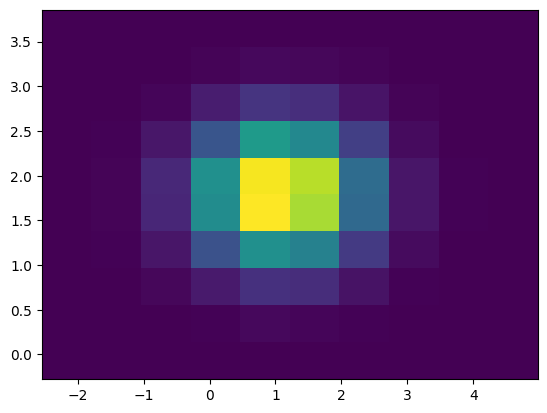

In [3]:
print(stuff.shape)
plt.hist2d( stuff[:,0], stuff[:,1] )

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
#tf.config.experimental.set_virtual_device_configuration(
#    gpus[1],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
N = 10**5

# Synthetic
theta0_G = np.column_stack((
    np.random.normal(1.1, 0.8, N),   # 1 dee
    np.random.normal(1.8, 0.5, N)    # 2 dee
))

theta0_S = np.random.normal(0, 0.5, (N, 2)) + theta0_G  # Detector smearing for synthetic sample but different

theta0 = np.stack((theta0_G, theta0_S), axis=1)  # axis=1 to maintain stack property

# Natural
theta_unknown_G = np.column_stack([
    np.random.normal(1, .5, N),   # First dimension
    np.random.normal(1.5, 0.3, N) # Second dimension
])

theta_unknown_S = np.random.normal(0, 0.5, (N,2)) + theta_unknown_G

print("Shape theta0_G:", theta0_G.shape)
print("Shape 0_S:", theta0_S.shape)
print("Shape theta0:", theta0.shape)
print("Shape unknown s:", theta_unknown_S.shape)


Shape theta0_G: (100000, 2)
Shape 0_S: (100000, 2)
Shape theta0: (100000, 2, 2)
Shape unknown s: (100000, 2)


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 5.000e+00,
        8.000e+00, 7.000e+00, 1.200e+01, 1.900e+01, 2.400e+01, 3.600e+01,
        6.400e+01, 7.700e+01, 1.090e+02, 1.490e+02, 2.050e+02, 2.690e+02,
        3.520e+02, 5.250e+02, 6.200e+02, 7.680e+02, 1.035e+03, 1.193e+03,
        1.449e+03, 1.837e+03, 2.117e+03, 2.450e+03, 2.878e+03, 3.128e+03,
        3.483e+03, 3.842e+03, 4.045e+03, 4.379e+03, 4.572e+03, 4.587e+03,
        4.642e+03, 4.821e+03, 4.756e+0

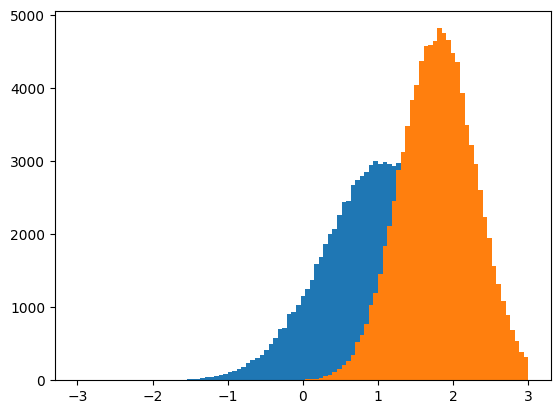

In [6]:
plt.hist( theta0_G[:,0], bins=np.linspace(-3,3, 100) )
plt.hist( theta0_G[:,1], bins=np.linspace(-3,3, 100) )

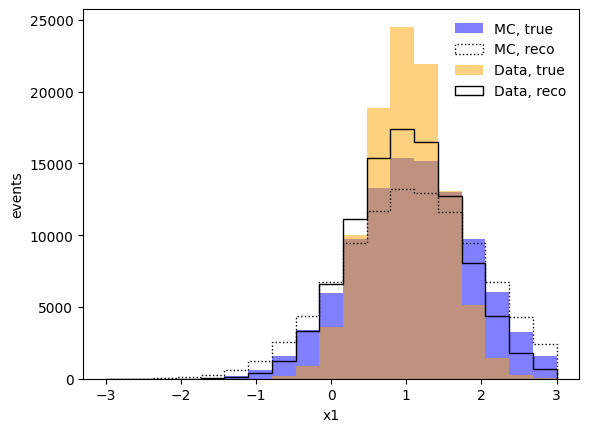

In [7]:
_,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta0_S[:,0],bins=np.linspace(-3,3,20),histtype="step",color='black',ls=':',label="MC, reco")
_,_,_=plt.hist(theta_unknown_G[:,0],bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta_unknown_S[:,0],bins=np.linspace(-3,3,20),histtype="step",color='black',label="Data, reco")
plt.xlabel("x1")
plt.ylabel("events")
plt.legend(frameon=False)


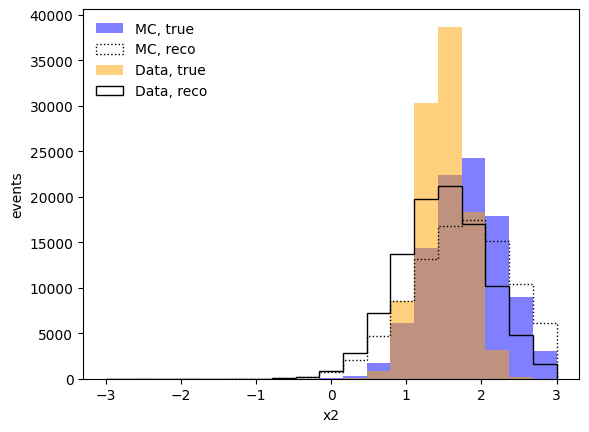

In [8]:
_,_,_=plt.hist(theta0_G[:,1],bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta0_S[:,1],bins=np.linspace(-3,3,20),histtype="step",color='black',ls=':',label="MC, reco")
_,_,_=plt.hist(theta_unknown_G[:, 1],bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta_unknown_S[:, 1],bins=np.linspace(-3,3,20),histtype="step",color='black',label="Data, reco")
plt.xlabel("x2")
plt.ylabel("events")
plt.legend(frameon=False)


In [9]:
# # test 4d
# np.random.seed(42)
# a = np.random.randint(0, 5, 100)
# b = np.random.randint(0, 5, 100)
# c = np.random.rand(100)
# d = np.random.rand(100)

# fig, axs = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(10, 10))

# for i in range(5):
#     for j in range(5):
#         #filter
#         mask = (a == i) & (b == j)
#         current_c = c[mask]
#         current_d = d[mask]

#         #scatter in sub
#         axs[i, j].scatter(current_c, current_d, s=10)

#         #labels
#         axs[i, j].set_xlabel('c')
#         axs[i, j].set_ylabel('d')

#         #title
#         axs[i, j].set_title(f'a={i}, b={j}')

# plt.tight_layout()
# plt.show()


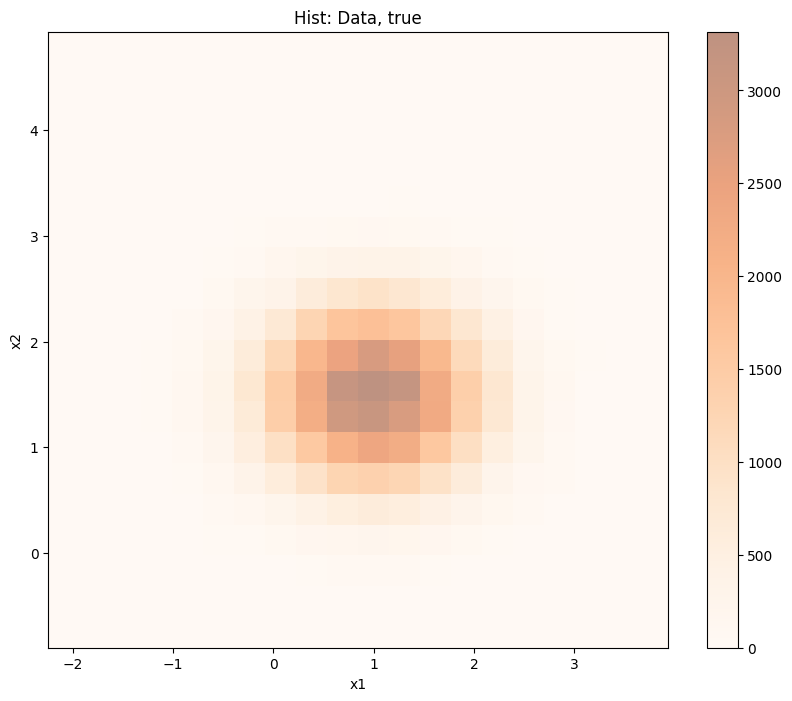

In [10]:
#Data, true
plt.figure(figsize=(10, 8))
plt.hist2d(theta_unknown_S[:, 0], theta_unknown_S[:, 1], bins=(20, 20), cmap='Oranges', alpha=0.5, label="Data, true")
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Hist: Data, true")
plt.show()

In [11]:
# #Data, true
# theshape=theta_unknown_S.shape
# print(theshape)
# N = theshape[0] * theshape[1]
# plt.figure(figsize=(10, 8))
# plt.hist(theta_unknown_S.reshape(N), cmap='Oranges', alpha=0.5, label="Data, true")
# plt.show()

In [12]:
# _, _, _ = plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), cmap='Blues', alpha=0.5, label="MC, true")
# _, _, _ = plt.hist2d(theta_unknown_G[:, 0], theta_unknown_G[:, 1], bins=(20, 20), cmap='Oranges', alpha=0.5, label="Data, true")
# _, _, _ = plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), weights=myweights[-1, 0, :], cmap='Greys', alpha=0.5, label="OmniFolded")
# plt.xlabel("x1")
# plt.ylabel("x2")
# plt.legend(frameon=False)
# plt.show()


In [13]:
inputs = Input((2,))  # 2D input
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

2023-11-16 16:54:44.537016: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-16 16:54:44.537036: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-16 16:54:44.537040: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-16 16:54:44.537070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-16 16:54:44.537083: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
myweights = of.omnifold(theta0,theta_unknown_S,5,model)

theta0G (100000, 2), labels (100000,), labels unknown (100000,), theta 0(100000, 2, 2), theta unknown s(100000, 2)


2023-11-16 16:54:44.838167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:54:45.123887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 2ms/step


2023-11-16 16:54:47.435689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:54:47.594467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:54:48.081959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 2ms/step


2023-11-16 16:56:06.423032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:56:06.586012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:56:06.838765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 2ms/step


2023-11-16 16:56:09.090837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:56:09.249559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:56:09.723488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 2ms/step


2023-11-16 16:57:27.327670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:57:27.480261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:57:27.719478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 2ms/step


2023-11-16 16:57:29.974854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:57:30.132768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:57:30.628093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 2ms/step


2023-11-16 16:58:49.360799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/dirkin/Documents/Research/lhc/alt/OmniFold/omnifold.py:8: RuntimeWarning: divide by zero encountered in divide
  weights = f / (1. - f)
2023-11-16 16:58:49.516676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:58:49.781160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 2ms/step


2023-11-16 16:58:52.048244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:58:52.205452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:58:52.717885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 3ms/step


2023-11-16 17:00:11.093479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 17:00:11.255557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 17:00:11.523296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 2ms/step


2023-11-16 17:00:13.791942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 17:00:13.951894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 17:00:14.477063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 2ms/step


2023-11-16 17:01:32.916561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [15]:
# #needless
# plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), cmap='Blues', alpha=0.5, label="MC, true")
# plt.hist2d(theta_unknown_G[:, 0], theta_unknown_G[:, 1], bins=(20, 20), cmap='Oranges', alpha=0.5, label="Data, true")
# plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), weights=myweights[-1, 0, :], cmap='Greys', alpha=0.5, label="OmniFolded")
# plt.xlabel("x1")
# plt.ylabel("x2")
# plt.legend(frameon=False)
# plt.show()

In [16]:
print("Shape theta0_G:", theta0_G.shape)
print("Shape weights:", myweights.shape)


Shape theta0_G: (100000, 2)
Shape weights: (5, 2, 100000)


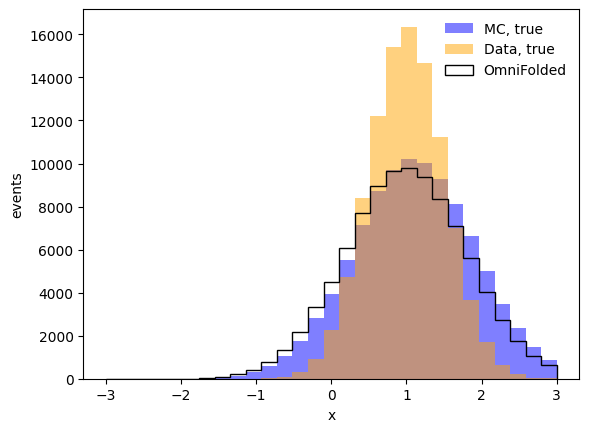

In [29]:
_,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,3,30),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta_unknown_G[:,0],bins=np.linspace(-3,3,30),color=['orange'],alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,3,30),weights=myweights[1, 0, :],color='black',histtype="step",label="OmniFolded")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

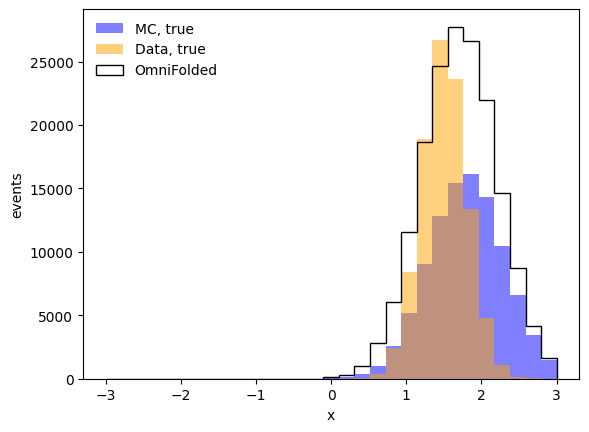

In [32]:
_,_,_=plt.hist(theta0_G[:,1],bins=np.linspace(-3,3,30),color=['blue'],alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta_unknown_G[:,1],bins=np.linspace(-3,3,30),color=['orange'],alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta0_G[:,1],bins=np.linspace(-3,3,30),weights=myweights[2, 0, :],color='black',histtype="step",label="OmniFolded")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

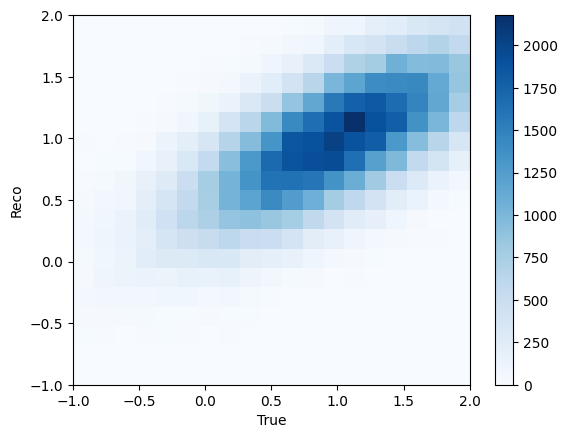

In [19]:
# Draw the response matrix    
plt.figure(1)
G, xbins2d, ybins2d, patches2d = plt.hist2d(theta_unknown_S[:,0],theta_unknown_G[:,0], bins=np.linspace(-1,2,20), weights=myweights[0, -1, :], cmap='Blues')
plt.xlabel('True')
plt.ylabel('Reco')
plt.colorbar()

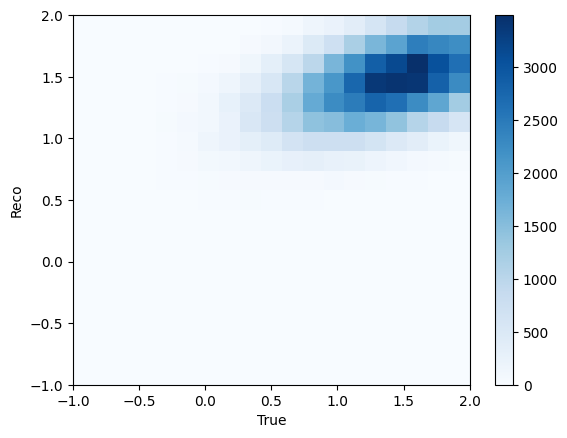

In [20]:
# Draw the response matrix    
plt.figure(1)
G, xbins2d, ybins2d, patches2d = plt.hist2d(theta_unknown_S[:,1],theta_unknown_G[:,1], bins=np.linspace(-1,2,20), weights=myweights[0, -1, :], cmap='Blues')
plt.xlabel('True')
plt.ylabel('Reco')
plt.colorbar()